In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sklearn as sk
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from cleaning import cleaning

In [21]:
computer = pd.read_csv('computer_subcategory_classification.csv')
computer.head()

,website_url,cleaned_website_text,Category
0,http://www.kasrl.org/jaffe.html,japanese female facial expression jaffe datase...,Computers and Technology
1,https://www.gmdhshell.com/,best predictive analytic software free academi...,Computers and Technology
2,http://en.wikipedia.org/wiki/Neural_network,neural network wikipedia neural network conten...,Computers and Technology
3,http://cadingandcoding.blogspot.com/,cading coding cading coding tuesday march auto...,Computers and Technology
4,http://www.panzercad.com/,welcome bluehost rate web host provider free c...,Computers and Technology


In [22]:
computer["Category"].value_counts()

Computers and Technology    93
Cyber Security              91
Cryptocurrency              80
Name: Category, dtype: int64

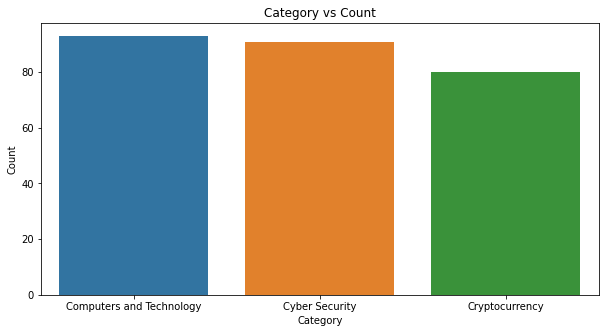

In [23]:
#Putting values into graph
plt.figure(figsize=(10,5))
plt.title("Category vs Count")
computer_category_count = pd.DataFrame(computer["Category"].value_counts())
sns.barplot(x=computer_category_count.index, y=computer_category_count["Category"])
plt.ylabel("Count")
plt.xlabel("Category")
plt.show()

### Cleaning the text

In [24]:
computer["cleaned_website_text"] = computer["cleaned_website_text"].apply(cleaning)
computer["cleaned_website_text"] = computer["cleaned_website_text"].apply(lambda x: ' '.join(x))
computer.head()

,website_url,cleaned_website_text,Category
0,http://www.kasrl.org/jaffe.html,japanese female facial expression jaffe datase...,Computers and Technology
1,https://www.gmdhshell.com/,best predictive analytic software free academi...,Computers and Technology
2,http://en.wikipedia.org/wiki/Neural_network,neural network wikipedia neural network conten...,Computers and Technology
3,http://cadingandcoding.blogspot.com/,cading cod cading cod tuesday march autocad gi...,Computers and Technology
4,http://www.panzercad.com/,welcome bluehost rate web host provider free c...,Computers and Technology


### Feature Extraction: Label Encoding

In [25]:
le = LabelEncoder()
computer["Category"] = le.fit_transform(computer["Category"])
computer.head()

,website_url,cleaned_website_text,Category
0,http://www.kasrl.org/jaffe.html,japanese female facial expression jaffe datase...,0
1,https://www.gmdhshell.com/,best predictive analytic software free academi...,0
2,http://en.wikipedia.org/wiki/Neural_network,neural network wikipedia neural network conten...,0
3,http://cadingandcoding.blogspot.com/,cading cod cading cod tuesday march autocad gi...,0
4,http://www.panzercad.com/,welcome bluehost rate web host provider free c...,0


In [26]:
#splitting dataset
X_train,X_test,y_train,y_test = train_test_split(computer["cleaned_website_text"], computer["Category"], test_size=0.2, random_state=42)
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((211,), (53,), (211,), (53,))

In [27]:
#TF-IDF
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

X_train_tfidf = X_train_tfidf.toarray()
X_test_tfidf = X_test_tfidf.toarray()

### Training Model Pipeline

In [33]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Assuming you have your training data (X_train) and corresponding labels (y_train)

# Define the models and their respective hyperparameters to try during grid search
models = {
    'MNB': {
        'model': MultinomialNB(),
        'params': {
            'mnb__alpha': [0.1, 0.5, 1.0, 1.5, 2.0]
        }
    },
    'SVM': {
        'model': SVC(),
        'params': {
            'svm__C': [1, 10, 100],
            'svm__kernel': ['linear', 'rbf']
        }
    },
    'Decision Tree': {
        'model': DecisionTreeClassifier(),
        'params': {
            'decision tree__criterion': ['gini', 'entropy'],
            'decision tree__max_depth': [None, 5, 10, 15, 20, 25, 30],
            'decision tree__min_samples_split': [2, 5, 10, 15, 20, 25, 30],
            'decision tree__min_samples_leaf': [1, 2, 5, 10, 15, 20, 25, 30],
            'decision tree__max_features': ['sqrt', 'log2', None],
            'decision tree__class_weight': ['balanced', None],
            'decision tree__random_state': [42],
            'decision tree__splitter': ['best', 'random'],
        }
    }
}

# Perform grid search and cross-validation for each model
for model_name, model_data in models.items():
    print("Evaluating:", model_name)
    
    # Create a pipeline with a TF-IDF vectorizer and the current model
    pipeline = Pipeline([
        (model_name.lower(), model_data['model'])
    ])
    
    # Define the hyperparameters for the current model
    parameters = model_data['params']
    
    # Perform grid search with 5-fold cross-validation
    grid_search = GridSearchCV(pipeline, parameters, cv=5, scoring='accuracy')
    grid_search.fit(X_train_tfidf, y_train)
    
    # Get the best model and its corresponding hyperparameters
    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_
    
    # Make predictions on the test set
    y_pred = best_model.predict(X_test_tfidf)
    
    # Calculate and print evaluation metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    print("Best parameters:", best_params)
    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1 score:", f1)
    print("----------------------------------")

Evaluating: MNB
Best parameters: {'mnb__alpha': 1.5}
Accuracy: 0.9811320754716981
Precision: 0.9820305480682839
Recall: 0.9811320754716981
F1 score: 0.9810926303333114
----------------------------------
Evaluating: SVM
Best parameters: {'svm__C': 10, 'svm__kernel': 'linear'}
Accuracy: 0.9811320754716981
Precision: 0.9820305480682839
Recall: 0.9811320754716981
F1 score: 0.9810926303333114
----------------------------------
Evaluating: Decision Tree
Best parameters: {'decision tree__class_weight': 'balanced', 'decision tree__criterion': 'gini', 'decision tree__max_depth': None, 'decision tree__max_features': None, 'decision tree__min_samples_leaf': 1, 'decision tree__min_samples_split': 30, 'decision tree__random_state': 42, 'decision tree__splitter': 'best'}
Accuracy: 0.9245283018867925
Precision: 0.9273156089193825
Recall: 0.9245283018867925
F1 score: 0.924105491253105
----------------------------------


In [34]:
model = MultinomialNB(alpha=1.5)
model.fit(X_train_tfidf, y_train)

MultinomialNB(alpha=1.5)

In [36]:
import sklearn.metrics as sm

y_pred = model.predict(X_test_tfidf)

print(f'The accuracy of train model is {sm.accuracy_score(y_train,model.predict(X_train_tfidf))}')
print(f'The accuracy of test model is {sm.accuracy_score(y_test,y_pred)}')

The accuracy of train model is 0.990521327014218
The accuracy of test model is 0.9811320754716981


In [39]:
import sys
sys.path.append('../../scraping')
import ScrapTool

def website_prediction(website,model):
    scrapTool = ScrapTool()
    try:
        web = dict(scrapTool.visit_url(website))
        text = cleaning(web['website_text'])
        prediction = model.predict(text)
        print(f'The website is under the category of {le.inverse_transform(prediction)[0]}')
    except:
        print("Connection Timeout")

In [40]:
import pickle

filename = 'CompSubCat.sav'
pickle.dump(model, open(filename, 'wb'))

#loading the model
loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.score(X_test_tfidf, y_test)
print(result)

0.9811320754716981


              precision    recall  f1-score   support

           0       0.94      1.00      0.97        17
           1       1.00      1.00      1.00        15
           2       1.00      0.95      0.98        21

    accuracy                           0.98        53
   macro avg       0.98      0.98      0.98        53
weighted avg       0.98      0.98      0.98        53



<AxesSubplot:>

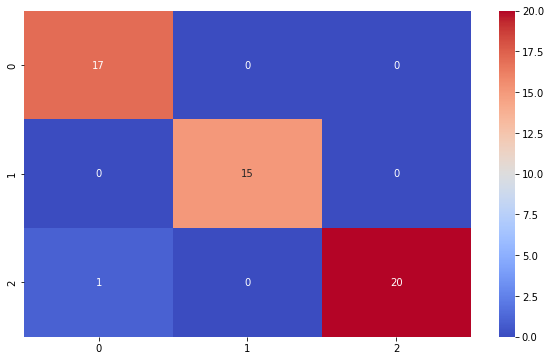

In [41]:
plt.figure(figsize=(10,6))
predictions = model.predict(X_test_tfidf)
print(classification_report(predictions,y_test))
sns.heatmap(confusion_matrix(predictions,y_test),cmap='coolwarm',annot=True)

In [43]:
pd.set_option('display.max_rows', None)
predictions = model.predict(X_test_tfidf)
pd.DataFrame({'Cleaned Text':X_test,'Actual':y_test,'Predicted':predictions})

,Cleaned Text,Actual,Predicted
68,tagspace versatile file organizer tagspaces op...,0,0
194,alienvault att cybersecurity att cybersecurity...,2,2
82,juggle home page j unix platform mailing list ...,0,0
247,firewall management network security policy so...,2,2
109,cryptocurrency exchange australia uk coinjares...,1,1
118,bitcoin rise cypherpunks coindeskcoindesk cont...,1,1
113,bitcoin forumbitcoin forum bitcoin opensource ...,1,1
178,symantec enterprise cloudto meet today cyber s...,2,2
9,jean loup home page home page jean loup gailly...,0,0
251,enterprise cybersecurity solution service trai...,2,2
